In [1]:
import sys, os
sys.path.insert(0, '../')
sys.path.insert(0, '../python_src/')

import numpy as np
import scipy as sp
import numpy.random as rand
import gzip
import cPickle as pickle
import matplotlib.pyplot as plt; plt.rcdefaults()
import seaborn as sns
%matplotlib inline

sns.set(color_codes=True)
sns.set_context('poster', font_scale=1.75)
sns.set_palette("hls", 8)
# sns.set_palette("muted", 8)
sns.set_style('ticks', {'xtick.direction': 'in','ytick.direction': 'in', 'axes.linewidth': 2.0})


import mech_network_solver as mns
import network
import tuning_algs as talgs
import network_plot as nplot

Loading Mechanical Network Deformation Solver Module


In [4]:
DIM = 2

Lp = -1.0

NN = 512
Lp = -1.0
irec = 11
NTS = 49
eta = 1e-1

def cantor(k1, k2):
    return (k1 + k2) * (k1 + k2 + 1) / 2 + k2

rand.seed(cantor(cantor(cantor(int(np.log2(NN)) % 128, NTS % 256), 
                        int(np.floor(100*np.abs(np.log10(eta))))  ), irec) % 4294967295)

nw_label = "network_periodic_jammed/network_N{:05d}_Lp{:.2f}/network_irec{:04d}".format(NN, Lp, irec)

with open("/data1/home/rocks/data/{:}.pkl".format(nw_label), 'rb') as pkl_file:

    nw_data = pickle.load(pkl_file)
    net = nw_data['network']    

NF = 1

edgei = net.edgei
edgej = net.edgej


inodesi = [[] for t in range(NF)]
inodesj = [[] for t in range(NF)]

onodesi = [[] for t in range(NF)]
onodesj = [[] for t in range(NF)]

# edge = range(net.NE)

# rand.shuffle(edge)

# b = edge.pop()

# inodesi[0].append(edgei[b])
# inodesj[0].append(edgej[b])

# for i in range(NTS):
#     b = edge.pop()

#     onodesi[0].append(edgei[b])
#     onodesj[0].append(edgej[b])

gsize = int(np.ceil((NTS+1)**(1.0/DIM)))

print gsize


edge_set = set()

sites = list(rand.choice(np.arange(gsize**2), NTS+1, replace=False))

site = sites.pop()
si = site / gsize
sj = site % gsize


b = network.closestEdge(net, np.array([net.L[0] * si / gsize, net.L[1] * sj / gsize]))[0]


edge_set.add(b)

inodesi[0].append(edgei[b])
inodesj[0].append(edgej[b])

for i in range(NTS):
    
    site = sites.pop()
    si = site / gsize
    sj = site % gsize
    
    blist = network.closestEdge(net, np.array([net.L[0] * si / gsize, net.L[1] * sj / gsize]))

    for b in blist:
        if b in edge_set:
            continue
        else:
            edge_set.add(b)
            onodesi[0].append(edgei[b])
            onodesj[0].append(edgej[b])
            break

print len(edge_set)
        
print "inodes", inodesi, inodesj

print "onodes", onodesi, onodesj

isvec = [[] for t in range(NF)]
for t in range(NF):
    for (i, j) in zip(inodesi[t], inodesj[t]):
        posi = net.node_pos[DIM*i:DIM*i+DIM]
        posj = net.node_pos[DIM*j:DIM*j+DIM]
        bvec = posj - posi
        bvec -= np.round(bvec/net.L)*net.L
        isvec[t].extend(bvec) 

istrain = [[] for t in range(NF)]
istrain[0].append(1.0)


osvec = [[] for t in range(NF)]
ostrain = [[] for t in range(NF)]
for t in range(NF):
    for (i, j) in zip(onodesi[t], onodesj[t]):
        posi = net.node_pos[DIM*i:DIM*i+DIM]
        posj = net.node_pos[DIM*j:DIM*j+DIM]
        bvec = posj - posi
        bvec -= np.round(bvec/net.L)*net.L
        osvec[t].extend(bvec) 

        r = rand.randint(2)
        ostrain[t].append((2*r-1) * eta)

pert = []
meas = []
for t in range(NF):
    pert.append(talgs.Perturb())
    pert[t].setInputStrain(len(inodesi[t]), inodesi[t], inodesj[t], istrain[t], isvec[t], [])

    meas.append(talgs.Measure())
    meas[t].setOutputStrain(len(onodesi[t]), onodesi[t], onodesj[t], osvec[t], [])

obj_func = mns.CyIneqRatioChangeObjFunc(len(np.concatenate(ostrain)), net.NE, 
                                        np.zeros(len(np.concatenate(ostrain)), float), np.concatenate(ostrain))    


K_init = np.ones(net.NE, float) / net.eq_length

# tuner = talgs.TuneDiscLin(net, pert, meas, obj_func, K_init, NDISC=1)

# tuner.solver.setIntStrengths(K_init)

8
50
inodes [[1]] [[368]]
onodes [[423, 31, 93, 29, 54, 493, 472, 215, 189, 23, 386, 73, 257, 259, 244, 360, 387, 65, 133, 164, 206, 90, 123, 345, 225, 239, 212, 358, 306, 269, 62, 0, 10, 334, 330, 445, 258, 307, 159, 276, 242, 325, 193, 158, 477, 350, 303, 177, 280]] [[112, 471, 393, 183, 485, 440, 119, 504, 311, 42, 446, 323, 346, 314, 337, 370, 203, 425, 235, 385, 287, 318, 338, 478, 400, 118, 466, 490, 324, 359, 184, 202, 231, 430, 58, 467, 2, 238, 500, 352, 508, 426, 319, 291, 470, 136, 479, 46, 433]]


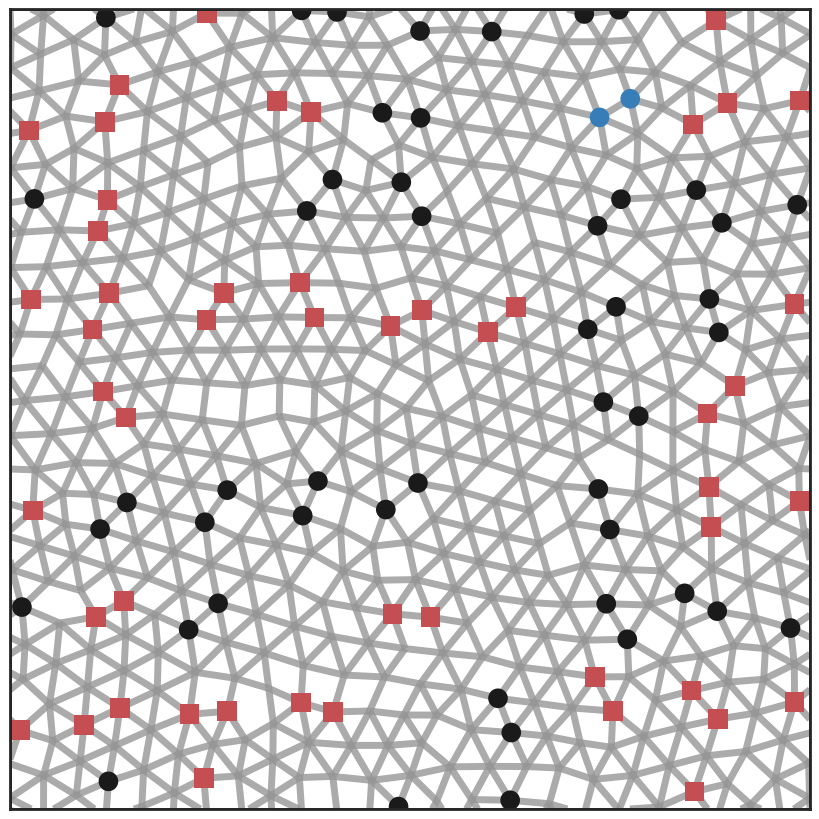

In [5]:
nplot.frame(net, np.zeros(DIM*net.NN, float), np.zeros([DIM, DIM], float), K_init, pert[0], meas[0], "", 
            boxsize=0.5, padding=0.00, save=False, show_removed=True, ostrain=ostrain[0])